In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from time import clock
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture 
from collections import defaultdict
import itertools
import timeit
from keras.layers import Input,Dense, Dropout
from keras.models import Model,Sequential
import seaborn as sns
from collections import Counter
from keras.models import load_model
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import adjusted_mutual_info_score,adjusted_rand_score,v_measure_score, completeness_score, homogeneity_score, silhouette_score,roc_curve, auc, f1_score, precision_recall_curve, precision_score,recall_score,accuracy_score,confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('/Users/chenpete/Documents/ESP/practicum/autoencoders/code/')

from utils import *

Using TensorFlow backend.


In [6]:
DATA_DIR = '/Users/PeterC/Documents/gt/practicum/autoencoders/data/'
DATA_DIR = '/Users/chenpete/Documents/ESP/practicum/autoencoders/data/'

non_scale_cols = ['time','y_early','y_rank','y']
param_cols = [
        'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29',
       'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39',
       'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49',
       'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59',
       'x60','x61']

y_col = 'y_early'
early_step = 4

df = pd.read_csv(DATA_DIR + 'paper_mill_rare_events.csv')
df['time'] = pd.to_datetime(df['time'])
X_train, X_test, y_train, y_test,y_rank_train, y_rank_test = preprocess_data(df,param_cols,y_col, non_scale_cols,early_step)

## Scale datasets with standard scaler

In [7]:
cluster_list = [2,4,6,8,10,12,14]
cluster_dict,labels = fit_clusters(X_train,y_train,method = 'km',clusters = cluster_list)

### Pre clustering - KM

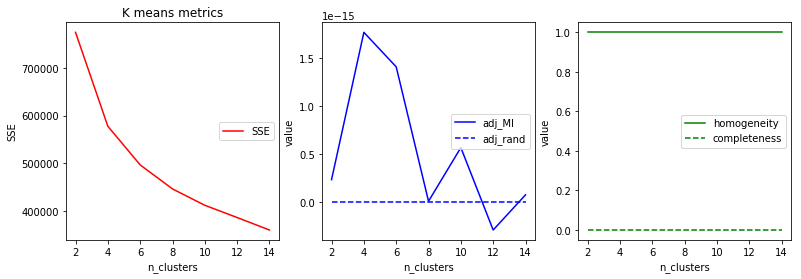

In [8]:
plot_clusters(cluster_dict)

#### Best cluster seems like 5

#### Training set - set threshold

In [7]:
n_cluster = 5
model=KMeans(n_clusters=n_cluster,random_state=0)
model.fit(X_train)
labels_train = model.predict(X_train)

distances_train = model.transform(X_train)
mean_distances = np.mean(distances_train,axis=1)
threshold_nonfailures = np.mean(mean_distances) + 3*np.std(mean_distances)
threshold_nonfailures 

18.211828010718477

#### Testing set - classification

In [8]:
early1_idx = y_rank_test == 1
normal_idx = y_rank_test == 0

X_test_early1 = X_test[early1_idx | normal_idx]
y_test_early1 = y_test[early1_idx| normal_idx]

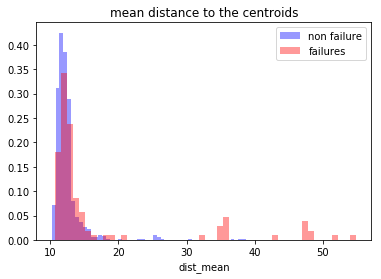

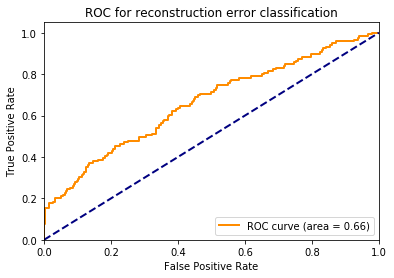

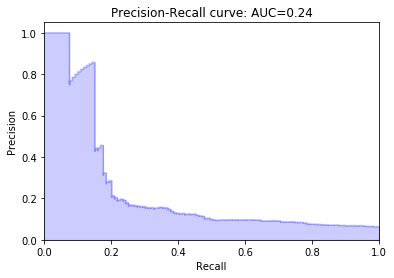

f1 score = 0.253
precision score = 0.447
recall score = 0.176


In [21]:
distances_test = model.transform(X_test_early1)
dist_mean = np.mean(distances_test,axis=1)
df_distances = pd.DataFrame(data = {'dist_mean':dist_mean,
                                    'y':y_test_early1,
                                    'yhat': np.where(dist_mean>threshold_nonfailures,1,0),
                                    'yhat_proba': dist_mean/np.max(dist_mean)
                                   })
plt.figure()
sns.distplot(df_distances[df_distances['y']==0]['dist_mean'],color='blue',kde=False,norm_hist=True)
sns.distplot(df_distances[df_distances['y']==1]['dist_mean'],color='red',kde=False,norm_hist=True)
plt.title('mean distance to the centroids')
plt.legend(['non failure','failures'])

plot_roc(df_distances['y'],df_distances['yhat_proba'])
plot_pr_curve(df_distances['y'],df_distances['yhat_proba'])

print('f1 score = {:.3f}'.format(f1_score(df_distances['y'],df_distances['yhat'])))
print('precision score = {:.3f}'.format(precision_score(df_distances['y'],df_distances['yhat'])))
print('recall score = {:.3f}'.format(recall_score(df_distances['y'],df_distances['yhat'])))

### Clustering the encoded layers

In [11]:
autoencoder_model = load_model('autoencoder_32_16_32.h5')

encoded_model = Sequential()
encoded_model.add(Dense(units = 32,activation='relu',input_shape = (len(param_cols),),weights = autoencoder_model.layers[0].get_weights()))
encoded_model.add(Dense(units = 16,activation='relu',weights = autoencoder_model.layers[1].get_weights()))

X = X_train.append(X_test)
encoded_array = encoded_model.predict(X)
encoded_array_train = encoded_model.predict(X_train)
encoded_array_test = encoded_model.predict(X_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [12]:
n_cluster = 5
km_encoded =KMeans(n_clusters=n_cluster,random_state=0)

km_encoded.fit(encoded_array_train)
labels_train_encoded = km_encoded.predict(encoded_array_train)
distances_train_encoded = km_encoded.transform(encoded_array_train)
mean_dist_train_encoded = np.mean(distances_train_encoded,axis=1)
threshold_nonfailures_encoded = np.mean(mean_dist_train_encoded) + 3*np.std(mean_dist_train_encoded)
threshold_nonfailures_encoded 

15.445129632949829

f1 score = 0.022
precision score = 0.032
recall score = 0.017


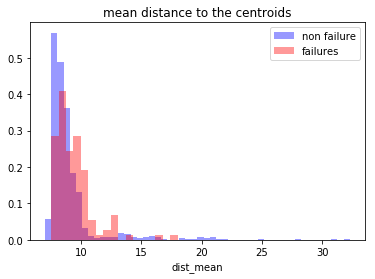

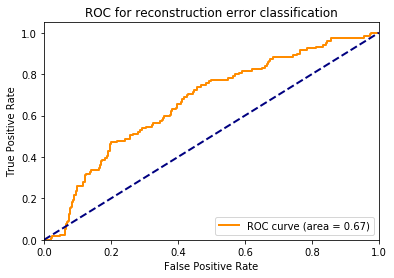

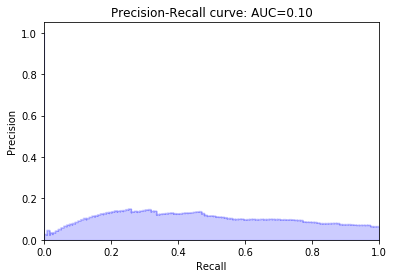

In [24]:
X_test_early1_encoded =encoded_array_test[early1_idx | normal_idx]

distances_test_encoded = km_encoded.transform(X_test_early1_encoded)
dist_mean_encoded = np.mean(distances_test_encoded,axis=1)
df_distances_encoded = pd.DataFrame(data = {'dist_mean':dist_mean_encoded,'y':y_test_early1,'yhat': np.where(dist_mean_encoded>threshold_nonfailures_encoded,1,0)
                                           ,'yhat_proba': dist_mean_encoded/np.max(dist_mean_encoded)
                                   })

plt.figure()
sns.distplot(df_distances_encoded[df_distances_encoded['y']==0]['dist_mean'],color='blue',kde=False,norm_hist=True)
sns.distplot(df_distances_encoded[df_distances_encoded['y']==1]['dist_mean'],color='red',kde=False,norm_hist=True)
plt.title('mean distance to the centroids')
plt.legend(['non failure','failures'])

print('f1 score = {:.3f}'.format(f1_score(df_distances_encoded['y'],df_distances_encoded['yhat'])))
print('precision score = {:.3f}'.format(precision_score(df_distances_encoded['y'],df_distances_encoded['yhat'])))
print('recall score = {:.3f}'.format(recall_score(df_distances_encoded['y'],df_distances_encoded['yhat'])))

plot_roc(df_distances_encoded['y'],df_distances_encoded['yhat_proba'])
plot_pr_curve(df_distances_encoded['y'],df_distances_encoded['yhat_proba'])

In [25]:
import ast

autoencoder_model = load_model('autoencoder_12_6_12.h5')
param_cols_xgb = ast.literal_eval(autoencoder_model.name)
encoded_model_xgb = Sequential()
encoded_model_xgb.add(Dense(units = 12,activation='relu',input_shape = (len(param_cols_xgb),),weights = autoencoder_model.layers[0].get_weights()))
encoded_model_xgb.add(Dense(units = 6,activation='relu',weights = autoencoder_model.layers[1].get_weights()))

In [26]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb,y_rank_train_xgb, y_rank_test_xgb = preprocess_data(df,param_cols_xgb,y_col, non_scale_cols,early_step)

### Clustering using top 15 XGBoost features

In [27]:
model_xgb=KMeans(n_clusters=n_cluster,random_state=0)
model_xgb.fit(X_train_xgb)

labels_train_xgb = model_xgb.predict(X_train_xgb)

distances_train_xgb = model_xgb.transform(X_train_xgb)
mean_distances_xgb = np.mean(distances_train_xgb,axis=1)
threshold_nonfailures_xgb = np.mean(mean_distances_xgb) + 3*np.std(mean_distances_xgb)
threshold_nonfailures_xgb 

9.120801237504043

f1 score = 0.071
precision score = 0.122
recall score = 0.050


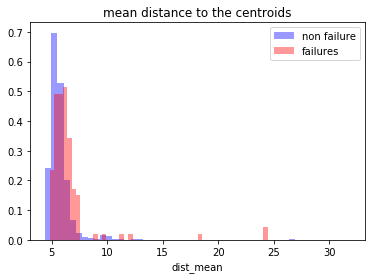

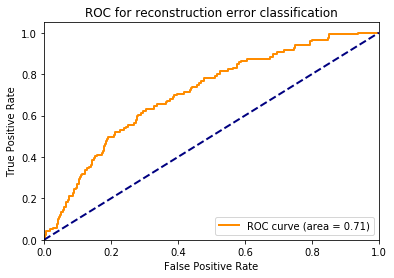

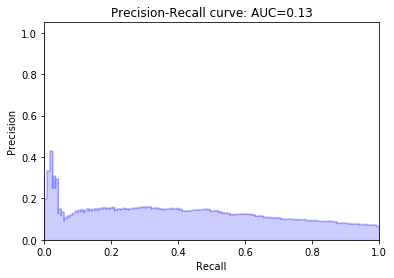

In [32]:
X_test_early1_xgb = X_test_xgb[early1_idx | normal_idx]
y_test_early1_xgb = y_test_xgb[early1_idx| normal_idx]

distances_test_xgb = model_xgb.transform(X_test_early1_xgb)
dist_mean_xgb= np.mean(distances_test_xgb,axis=1)
df_distances_xgb = pd.DataFrame(data = {'dist_mean':dist_mean_xgb,'y':y_test_early1,'yhat': np.where(dist_mean_xgb>threshold_nonfailures_xgb,1,0)
                                                                                  ,'yhat_proba': dist_mean_xgb/np.max(dist_mean_xgb)
                                   })

plt.figure()
sns.distplot(df_distances_xgb[df_distances_xgb['y']==0]['dist_mean'],color='blue',kde=False,norm_hist=True)
sns.distplot(df_distances_xgb[df_distances_xgb['y']==1]['dist_mean'],color='red',kde=False,norm_hist=True)
plt.title('mean distance to the centroids')
plt.legend(['non failure','failures'])

print('f1 score = {:.3f}'.format(f1_score(df_distances_xgb['y'],df_distances_xgb['yhat'])))
print('precision score = {:.3f}'.format(precision_score(df_distances_xgb['y'],df_distances_xgb['yhat'])))
print('recall score = {:.3f}'.format(recall_score(df_distances_xgb['y'],df_distances_xgb['yhat'])))


plot_roc(df_distances_xgb['y'],df_distances_xgb['yhat_proba'])
plot_pr_curve(df_distances_xgb['y'],df_distances_xgb['yhat_proba'])

### Clustering the encoded layers - using top 15 XGBoost features

In [34]:
X_xgb = X_train_xgb.append(X_test_xgb)
encoded_xgb_array = encoded_model_xgb.predict(X_xgb)
encoded_xgb_array_train = encoded_model_xgb.predict(X_train_xgb)
encoded_xgb_array_test = encoded_model_xgb.predict(X_test_xgb)

In [35]:
n_cluster = 5
km_encoded_xgb =KMeans(n_clusters=n_cluster,random_state=0)

km_encoded_xgb.fit(encoded_xgb_array_train)
labels_train_encoded_xgb = km_encoded_xgb.predict(encoded_xgb_array_train)
distances_train_encoded_xgb = km_encoded_xgb.transform(encoded_xgb_array_train)
mean_dist_train_encoded_xgb = np.mean(distances_train_encoded_xgb,axis=1)
threshold_nonfailures_encoded_xgb = np.mean(mean_dist_train_encoded_xgb) + 3*np.std(mean_dist_train_encoded_xgb)
threshold_nonfailures_encoded_xgb 

9.13591718673706

f1 score = 0.026
precision score = 0.057
recall score = 0.017


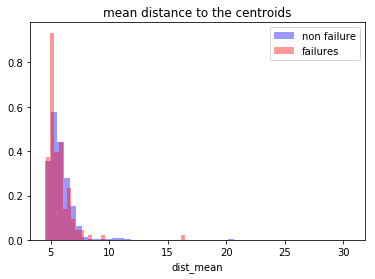

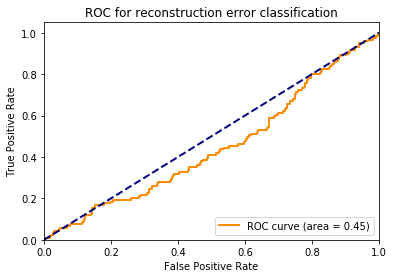

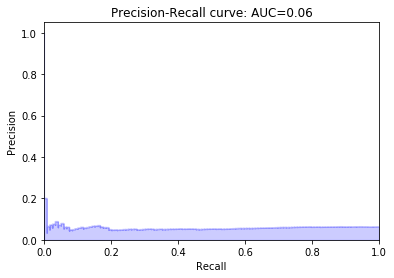

In [36]:
X_test_early1_encoded_xgb =encoded_xgb_array_test[early1_idx | normal_idx]

distances_test_encoded_xgb = km_encoded_xgb.transform(X_test_early1_encoded_xgb)
dist_mean_encoded_xgb = np.mean(distances_test_encoded_xgb,axis=1)
df_distances_encoded_xgb = pd.DataFrame(data = {'dist_mean':dist_mean_encoded_xgb,'y':y_test_early1,'yhat': np.where(dist_mean_encoded_xgb>threshold_nonfailures_encoded_xgb,1,0)
                                                                                  ,'yhat_proba': dist_mean_encoded_xgb/np.max(dist_mean_encoded_xgb)
                                   })

plt.figure()
sns.distplot(df_distances_encoded_xgb[df_distances_encoded_xgb['y']==0]['dist_mean'],color='blue',kde=False,norm_hist=True)
sns.distplot(df_distances_encoded_xgb[df_distances_encoded_xgb['y']==1]['dist_mean'],color='red',kde=False,norm_hist=True)
plt.title('mean distance to the centroids')
plt.legend(['non failure','failures'])

print('f1 score = {:.3f}'.format(f1_score(df_distances_encoded_xgb['y'],df_distances_encoded_xgb['yhat'])))
print('precision score = {:.3f}'.format(precision_score(df_distances_encoded_xgb['y'],df_distances_encoded_xgb['yhat'])))
print('recall score = {:.3f}'.format(recall_score(df_distances_encoded_xgb['y'],df_distances_encoded_xgb['yhat'])))

plot_roc(df_distances_encoded_xgb['y'],df_distances_encoded_xgb['yhat_proba'])
plot_pr_curve(df_distances_encoded_xgb['y'],df_distances_encoded_xgb['yhat_proba'])